# <font size="6">Object Detection Inference on ANY slide (all section of tissue will be used)</font>

### <font size="5">Load model and params</font>

In [1]:
import torch
from icevision.all import *
from icevision.models import *

INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /home/aarlova/.icevision/mmdetection_configs/mmdetection_configs-2.20.1/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:17


In [2]:
torch.cuda.set_device(2)

In [3]:
checkpoint_path = 'YOLO_data/training_log/torchvision_fasterRCNN_10x.pth'

In [4]:
checkpoint_and_model = model_from_checkpoint(checkpoint_path)

load checkpoint from local path: YOLO_data/training_log/torchvision_fasterRCNN_10x.pth


/home/aarlova/anaconda3/envs/pytorch_lym_clone/lib/python3.9/site-packages/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  warnings.warn(
2022-11-30 10:13:39,655 - mmcv - INFO - initialize ResNet with init_cfg {'type': 'Pretrained', 'checkpoint': 'torchvision://resnet101'}
2022-11-30 10:13:39,661 - mmcv - INFO - load model from: torchvision://resnet101
2022-11-30 10:13:39,662 - mmcv - INFO - load checkpoint from torchvision path: torchvision://resnet101
2022-11-30 10:13:40,001 - mmcv - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2022-11-30 10:13:40,066 - mmcv - INFO - initialize FPN with init_cfg {'type': 'Xavier', 'layer': 'Conv2d', 'distribution': 'uniform'}
2022-11-30 10:13:40,127 - mmcv - INFO - initialize RPNHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01}
2022-11-30 10:13:40,137 - mmcv - INFO -

In [5]:
model_type = checkpoint_and_model["model_type"]
backbone = checkpoint_and_model["backbone"]
class_map = checkpoint_and_model["class_map"]
img_size = checkpoint_and_model["img_size"]

model_type, backbone, class_map, img_size

(<module 'icevision.models.mmdet.models.faster_rcnn' from '/home/aarlova/anaconda3/envs/pytorch_lym_clone/lib/python3.9/site-packages/icevision/models/mmdet/models/faster_rcnn/__init__.py'>,
 <ClassMap: {'background': 0, 'Follicle': 1}>,
 512)

In [6]:
# Get model object
# The model is automatically set in the evaluation mode
model = checkpoint_and_model["model"]
model.to(torch.device("cuda:2"))

FasterRCNN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [7]:
# Transforms
size = img_size

valid_tfms = tfms.A.Adapter([tfms.A.Resize(size, size), tfms.A.Normalize()])
print(img_size, valid_tfms)

512 <icevision.tfms.albumentations.albumentations_adapter.Adapter object at 0x7fa558a97760>


In [8]:
class_map = ClassMap(['Follicle'])

### <font size="5">Load image processing modules</font>

In [9]:
import openslide
import cv2
from skimage import morphology
import cv2 as cv
from shapely.geometry import Polygon, MultiPolygon, box
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import random
import numpy as np
from shapely.strtree import STRtree
from shapely.geometry import mapping
from pathlib import Path

import geojson



plt.rcParams['figure.dpi'] = 50 # for high resolution figure

In [10]:
#################################
# def simple_get_mask(img):
#     gray = cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2GRAY)
#     _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU) # threshold using the OTSU method
#     mask = morphology.remove_small_objects(mask == 0, min_size=1000, connectivity=2)
#     mask = morphology.remove_small_holes(mask, area_threshold=100)
#     mask = morphology.binary_dilation(mask, morphology.disk(5))
#     return mask

### for 7-24 slides

import cv2 as cv
from skimage.morphology import disk
from skimage import morphology
import numpy as np

def simple_get_mask(img):
    gray = cv.cvtColor(np.asarray(img), cv.COLOR_RGB2GRAY)
    _, mask = cv.threshold(gray, 0, 255, cv.THRESH_OTSU) # threshold using the OTSU method
    mask = morphology.remove_small_objects(mask == 0, min_size=200, connectivity=2)
    mask = morphology.remove_small_holes(mask, area_threshold=100)
    mask = morphology.binary_dilation(mask, morphology.disk(1))
    return mask

# check for artifacts of slide scanning (horizontal or vertical thin dark strips)
def is_artifact(minx, miny, maxx, maxy):
    x_to_y = (maxx-minx)/(maxy-miny)
    y_to_x = (maxy-miny)/(maxx-minx)
    # print('x_to_y ratio:', int(x_to_y), ', y_to_x ratio:', int(y_to_x))
    if x_to_y > 30 or y_to_x > 30:
        return True
    else:
        return False

# translate thumbnail-relative coords of Polygon to WSI-relative coords
def translate_coords(polys, thumbnail_downsample_factor):
    regions = []
    if polys.type == 'MultiPolygon':
        for i in range(len(polys.geoms)):
            new_ext_x = np.array(polys.geoms[i].exterior.coords.xy[0])*thumbnail_downsample_factor
            new_ext_y = np.array(polys.geoms[i].exterior.coords.xy[1])*thumbnail_downsample_factor
            new_coords = list(zip(new_ext_x, new_ext_y))
            regions.append(new_coords)
    if polys.type == 'Polygon':
        new_ext_x = np.array(polys.exterior.coords.xy[0]) * thumbnail_downsample_factor
        new_ext_y = np.array(polys.exterior.coords.xy[1]) * thumbnail_downsample_factor
        new_coords = list(zip(new_ext_x, new_ext_y))
        regions.append(new_coords)

    return regions

def get_tissue_regions(mask, thumbnail_downsample_factor):
    wsi_thumb_mask = mask.astype(np.uint8)

    contours, hierarchy = cv.findContours(wsi_thumb_mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    contours = [np.squeeze(i) for i in contours]  # removing redundant dimensions
    tissue_regions = [Polygon(i) for i in contours]

    tissue_regions = unary_union(tissue_regions)

    if tissue_regions.type == 'MultiPolygon':
        no_artifacts = MultiPolygon([geom for geom in tissue_regions.geoms if is_artifact(*geom.bounds) == False])
        tissue_regions = no_artifacts

    print('done cleaning')

    # visualize the resulting tissue_regions
    fig, axs = plt.subplots()
    axs.set_aspect('equal', 'datalim')
    axs.invert_yaxis()

    if tissue_regions.type == 'MultiPolygon':
        for geom in tissue_regions.geoms:
            xs, ys = geom.exterior.xy
            axs.plot(xs, ys, color='b', linestyle='-', linewidth=0.3)
    else:
        # for geom in tissue_regions:
        xs, ys = tissue_regions.exterior.xy
        axs.plot(xs, ys, color='b', linestyle='-', linewidth=0.3)

    plt.show()
    plt.cla()
    plt.clf()
    plt.close()

    translated_tissue_regions = translate_coords(tissue_regions, thumbnail_downsample_factor) # These are sections of tissue on the slide

    print('done translating')

    return translated_tissue_regions


def get_grid(polys, tile_size, ol, plot = False):
    slide_patches = []
    for i in range(len(polys)):
        margin_poly = Polygon(polys[i])
        minx, miny, maxx, maxy = margin_poly.bounds
        minx, miny, maxx, maxy = int(minx), int(miny), int(maxx), int(maxy)

        n_cols = int(np.ceil((maxx - minx) / (tile_size - ol)))
        n_rows = int(np.ceil((maxy - miny) / (tile_size - ol)))

        # all x's
        x_zero = int(margin_poly.bounds[0])
        xs = []
        xs.append(x_zero)
        for x in range(n_cols - 1):
            next_x = x_zero + (tile_size - ol)
            xs.append(next_x)
            x_zero = next_x

        # all y's
        y_zero = int(margin_poly.bounds[1])
        ys = []
        ys.append(y_zero)
        for y in range(n_rows - 1):
            next_y = y_zero + (tile_size - ol)
            ys.append(next_y)
            y_zero = next_y

        # assemble into rectangles
        patches = []
        for w in range(n_cols):
            x = xs[w]
            for z in range(n_rows):
                y = ys[z]
                rect = box(x, y, x + tile_size, y + tile_size, ccw=False)
                patches.append(rect)

        # find patches that intersect with tissue margin
        tree = STRtree(patches)
        query_geom = margin_poly
        intersects = [n for n in tree.query(query_geom) if n.intersects(query_geom) and n.intersection(query_geom).area/n.area > 0.05]

        # print('number of patches in this section: ', len(intersects))

        # append intersecting patches to slide_patches list
        slide_patches.append(intersects)

        if plot == True:
            # let's plot the intersecting ones
            fig, ax = plt.subplots()

            # plot main_poly
            ab = margin_poly.exterior.xy
            a, b = np.array(ab[0]), np.array(ab[1])
            ax.plot(a, b, color='b', linestyle='-', linewidth=0.4)
            ax.invert_yaxis()

            # plot other_polies
            patches = intersects
            color = ['r', 'g', 'b', 'c', 'y', 'm']
            for j in range(len(patches)):
                x, y = np.array(patches[j].exterior.xy[0]), np.array(patches[j].exterior.xy[1])
                plt.plot(x, y, color=color[random.randint(0, 5)], linestyle='-', linewidth=0.4)
            ax.grid(linestyle='--', linewidth='0.5')
            plt.title("Finding Intersecting Polys")
            plt.xlabel("X")
            plt.ylabel("Y")
            plt.axis('equal')
            plt.show()
            plt.cla()
            plt.clf()
            plt.close()

    return slide_patches

In [11]:
def write_qupath_noIDs_Polys(xmlsave, regions, region_labels, region_colors):
    dumped = []
    trythis = '['
    for i in range(0, len(regions)):
        # if len(regions[i]) >2:
            # roi = Polygon(regions[i])
        roi = regions[i]
        label = region_labels[i]
        trythis += json.dumps(
            {"type": "Feature", "id": "PathAnnotationObject", "geometry": mapping(roi),
             "properties": {"classification": {"name": label, "colorRGB": region_colors}, "isLocked": False,
                            "measurements": []}}, indent=4)
        if i < len(regions) - 1:
            trythis += ','
        else:
            dumped.append([region_labels[i], regions[i]])
    trythis += ']'

    with open(xmlsave, 'w') as outfile:
        outfile.write(trythis)
        
        dumped = []

In [12]:
def read_geojson(jsonpath):
    with open(jsonpath) as f:
        allobjects = geojson.load(f)

    #allshapes = [shape(obj["geometry"]) for obj in allobjects]
    allfeatures = allobjects['features']
    allshapes = [obj["geometry"]['coordinates'] for obj in allfeatures]
    alllabels = [obj['properties'] for obj in allfeatures]
    roilabels = list()
    for roi_num in range(0, len(alllabels)):
        roi_label = alllabels[roi_num]['classification']['name']
        roilabels.append(roi_label)
    
    return allshapes, roilabels

def read_geojson_nolabel(jsonpath):
    with open(jsonpath) as f:
        allobjects = geojson.load(f)

    #allshapes = [shape(obj["geometry"]) for obj in allobjects]
    allfeatures = allobjects['features']
    allshapes = [obj["geometry"]['coordinates'] for obj in allfeatures]
    alllabels = [obj['properties'] for obj in allfeatures]
    
    return allshapes

### <font size="5"> Open Slides and Run Inference! </font>

In [13]:
requested_magn = 10
downsample = int(40/requested_magn) # Use 4 for 10x, 2 for 20x, 1 for 40x
tile_size = int(500*downsample) # Use 2000 for 10x, 1000 for 20x, 500 for 40x
overlap = int(250*downsample)

In [14]:
json_dir = '/media/14TB/aarlova_ovarian/jsons/2000_jsons'
region_colors = -16274801

In [15]:
# jsons_dir_path = Path('margin_jsons_for_NIH')
# jsons = []
# for f in jsons_dir_path.iterdir():
#     if f.suffix == '.geojson':
#         jsons.append(str(f.name)[:-8])
        
# print(len(jsons))
# print(jsons)

# jsons = [j for j in jsons if jsons if '10921' not in j and '3561' not in j and '1205' not in j]
# print(len(jsons))

In [16]:
slide_dir = '/raid/aarlova/2000slides/Req 200550F FINAL/'

slide_list = ['17124731',
 '17124827',
 '17124828',
 '17124830',
 '17126436',
 '17126687',
 '17133327',
 '17133331',
 '17133874',
 '17133910',
 '17133913',
 '17145139']

In [18]:
for i in range(len(slide_list)):

    slide_fname = Path(slide_dir + '/' + slide_list[i] + '.svs')
    print('Working on Slide ', i, ' ', slide_fname)

Working on Slide  0   /raid/aarlova/2000slides/Req 200550F FINAL/17124731.svs
Working on Slide  1   /raid/aarlova/2000slides/Req 200550F FINAL/17124827.svs
Working on Slide  2   /raid/aarlova/2000slides/Req 200550F FINAL/17124828.svs
Working on Slide  3   /raid/aarlova/2000slides/Req 200550F FINAL/17124830.svs
Working on Slide  4   /raid/aarlova/2000slides/Req 200550F FINAL/17126436.svs
Working on Slide  5   /raid/aarlova/2000slides/Req 200550F FINAL/17126687.svs
Working on Slide  6   /raid/aarlova/2000slides/Req 200550F FINAL/17133327.svs
Working on Slide  7   /raid/aarlova/2000slides/Req 200550F FINAL/17133331.svs
Working on Slide  8   /raid/aarlova/2000slides/Req 200550F FINAL/17133874.svs
Working on Slide  9   /raid/aarlova/2000slides/Req 200550F FINAL/17133910.svs
Working on Slide  10   /raid/aarlova/2000slides/Req 200550F FINAL/17133913.svs
Working on Slide  11   /raid/aarlova/2000slides/Req 200550F FINAL/17145139.svs


Working on Slide  0   /raid/aarlova/2000slides/Req 200550F FINAL/17124731.svs
opened slide!


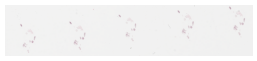

done cleaning


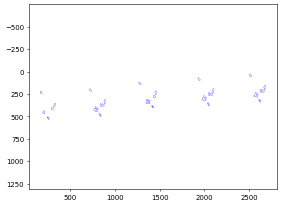

done translating
Set tile size to 2000 , and overlap to 1000
Done tiling the slide!
Number of sections in slide: 29
Number of tiles in current section: 4


/home/aarlova/anaconda3/envs/pytorch_lym_clone/lib/python3.9/site-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/home/aarlova/anaconda3/envs/pytorch_lym_clone/lib/python3.9/site-packages/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  warnings.warn(


done processing tiles in section 0
Number of tiles in current section: 4
done processing tiles in section 1
Number of tiles in current section: 3
done processing tiles in section 2
Number of tiles in current section: 2
done processing tiles in section 3
Number of tiles in current section: 4
done processing tiles in section 4
Number of tiles in current section: 4
done processing tiles in section 5
Number of tiles in current section: 4
done processing tiles in section 6
Number of tiles in current section: 12
done processing tiles in section 7
Number of tiles in current section: 4
done processing tiles in section 8
Number of tiles in current section: 4
done processing tiles in section 9
Number of tiles in current section: 4
done processing tiles in section 10
Number of tiles in current section: 4
done processing tiles in section 11
Number of tiles in current section: 4
done processing tiles in section 12
Number of tiles in current section: 3
done processing tiles in section 13
Number of t

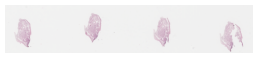

done cleaning


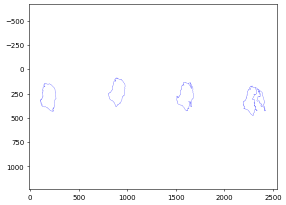

done translating
Set tile size to 2000 , and overlap to 1000
Done tiling the slide!
Number of sections in slide: 5
Number of tiles in current section: 167
done processing tiles in section 0
Number of tiles in current section: 161
done processing tiles in section 1
Number of tiles in current section: 165
done processing tiles in section 2
Number of tiles in current section: 138
done processing tiles in section 3
Number of tiles in current section: 57
done processing tiles in section 4
done with all sections
Detected  2144 raw bboxes on slide!
Len of unique preds on slide 738
Done saving JSON!
Working on Slide  2   /raid/aarlova/2000slides/Req 200550F FINAL/17124828.svs
opened slide!


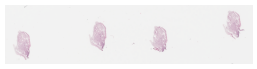

done cleaning


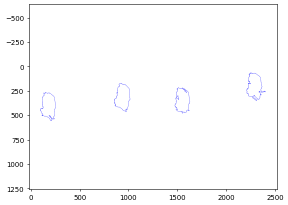

done translating
Set tile size to 2000 , and overlap to 1000
Done tiling the slide!
Number of sections in slide: 4
Number of tiles in current section: 166
done processing tiles in section 0
Number of tiles in current section: 167
done processing tiles in section 1
Number of tiles in current section: 152
done processing tiles in section 2
Number of tiles in current section: 168
done processing tiles in section 3
done with all sections
Detected  2527 raw bboxes on slide!
Len of unique preds on slide 795
Done saving JSON!
Working on Slide  3   /raid/aarlova/2000slides/Req 200550F FINAL/17124830.svs
opened slide!


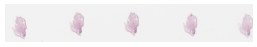

done cleaning


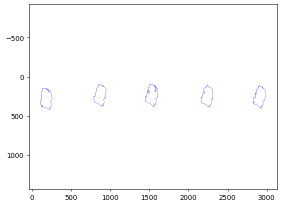

done translating
Set tile size to 2000 , and overlap to 1000
Done tiling the slide!
Number of sections in slide: 5
Number of tiles in current section: 152
done processing tiles in section 0
Number of tiles in current section: 153
done processing tiles in section 1
Number of tiles in current section: 162
done processing tiles in section 2
Number of tiles in current section: 150
done processing tiles in section 3
Number of tiles in current section: 153
done processing tiles in section 4
done with all sections
Detected  2403 raw bboxes on slide!
Len of unique preds on slide 825
Done saving JSON!
Working on Slide  4   /raid/aarlova/2000slides/Req 200550F FINAL/17126436.svs
opened slide!


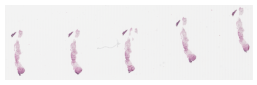

done cleaning


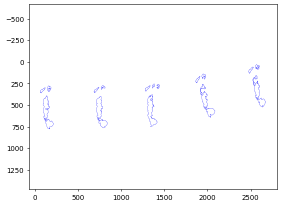

done translating
Set tile size to 2000 , and overlap to 1000
Done tiling the slide!
Number of sections in slide: 21
Number of tiles in current section: 11
done processing tiles in section 0
Number of tiles in current section: 118
done processing tiles in section 1
Number of tiles in current section: 12
done processing tiles in section 2
Number of tiles in current section: 10
done processing tiles in section 3
Number of tiles in current section: 7
done processing tiles in section 4
Number of tiles in current section: 69
done processing tiles in section 5
Number of tiles in current section: 37
done processing tiles in section 6
Number of tiles in current section: 11
done processing tiles in section 7
Number of tiles in current section: 112
done processing tiles in section 8
Number of tiles in current section: 12
done processing tiles in section 9
Number of tiles in current section: 11
done processing tiles in section 10
Number of tiles in current section: 128
done processing tiles in sec

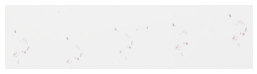

done cleaning


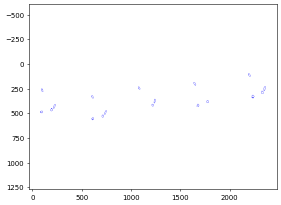

done translating
Set tile size to 2000 , and overlap to 1000
Done tiling the slide!
Number of sections in slide: 18
Number of tiles in current section: 2
done processing tiles in section 0
Number of tiles in current section: 2
done processing tiles in section 1
Number of tiles in current section: 2
done processing tiles in section 2
Number of tiles in current section: 4
done processing tiles in section 3
Number of tiles in current section: 4
done processing tiles in section 4
Number of tiles in current section: 2
done processing tiles in section 5
Number of tiles in current section: 4
done processing tiles in section 6
Number of tiles in current section: 2
done processing tiles in section 7
Number of tiles in current section: 3
done processing tiles in section 8
Number of tiles in current section: 4
done processing tiles in section 9
Number of tiles in current section: 4
done processing tiles in section 10
Number of tiles in current section: 4
done processing tiles in section 11
Number

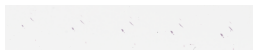

done cleaning


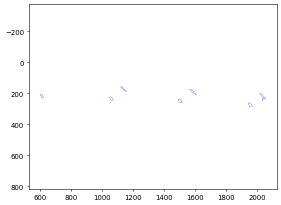

done translating
Set tile size to 2000 , and overlap to 1000
Done tiling the slide!
Number of sections in slide: 7
Number of tiles in current section: 4
done processing tiles in section 0
Number of tiles in current section: 5
done processing tiles in section 1
Number of tiles in current section: 3
done processing tiles in section 2
Number of tiles in current section: 7
done processing tiles in section 3
Number of tiles in current section: 4
done processing tiles in section 4
Number of tiles in current section: 4
done processing tiles in section 5
Number of tiles in current section: 4
done processing tiles in section 6
done with all sections
Detected  8 raw bboxes on slide!
Len of unique preds on slide 3
Done saving JSON!
Working on Slide  7   /raid/aarlova/2000slides/Req 200550F FINAL/17133331.svs
opened slide!


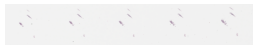

done cleaning


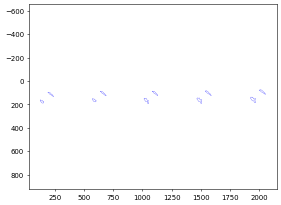

done translating
Set tile size to 2000 , and overlap to 1000
Done tiling the slide!
Number of sections in slide: 10
Number of tiles in current section: 6
done processing tiles in section 0
Number of tiles in current section: 7
done processing tiles in section 1
Number of tiles in current section: 6
done processing tiles in section 2
Number of tiles in current section: 8
done processing tiles in section 3
Number of tiles in current section: 4
done processing tiles in section 4
Number of tiles in current section: 4
done processing tiles in section 5
Number of tiles in current section: 6
done processing tiles in section 6
Number of tiles in current section: 7
done processing tiles in section 7
Number of tiles in current section: 8
done processing tiles in section 8
Number of tiles in current section: 8
done processing tiles in section 9
done with all sections
Detected  45 raw bboxes on slide!
Len of unique preds on slide 24
Done saving JSON!
Working on Slide  8   /raid/aarlova/2000slides/

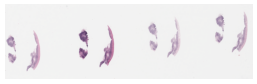

done cleaning


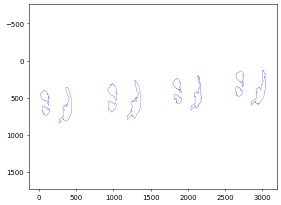

done translating
Set tile size to 2000 , and overlap to 1000
Done tiling the slide!
Number of sections in slide: 13
Number of tiles in current section: 73
done processing tiles in section 0
Number of tiles in current section: 187
done processing tiles in section 1
Number of tiles in current section: 49
done processing tiles in section 2
Number of tiles in current section: 70
done processing tiles in section 3
Number of tiles in current section: 91
done processing tiles in section 4
Number of tiles in current section: 218
done processing tiles in section 5
Number of tiles in current section: 47
done processing tiles in section 6
Number of tiles in current section: 60
done processing tiles in section 7
Number of tiles in current section: 122
done processing tiles in section 8
Number of tiles in current section: 18
done processing tiles in section 9
Number of tiles in current section: 50
done processing tiles in section 10
Number of tiles in current section: 76
done processing tiles in se

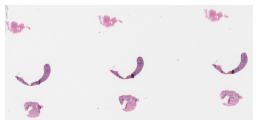

done cleaning


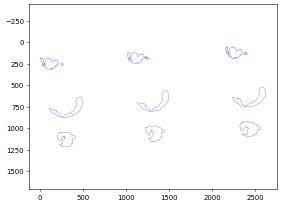

done translating
Set tile size to 2000 , and overlap to 1000
Done tiling the slide!
Number of sections in slide: 12
Number of tiles in current section: 101
done processing tiles in section 0
Number of tiles in current section: 4
done processing tiles in section 1
Number of tiles in current section: 149
done processing tiles in section 2
Number of tiles in current section: 126
done processing tiles in section 3
Number of tiles in current section: 95
done processing tiles in section 4
Number of tiles in current section: 96
done processing tiles in section 5
Number of tiles in current section: 9
done processing tiles in section 6
Number of tiles in current section: 152
done processing tiles in section 7
Number of tiles in current section: 134
done processing tiles in section 8
Number of tiles in current section: 158
done processing tiles in section 9
Number of tiles in current section: 6
done processing tiles in section 10
Number of tiles in current section: 140
done processing tiles in s

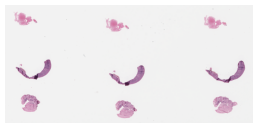

done cleaning


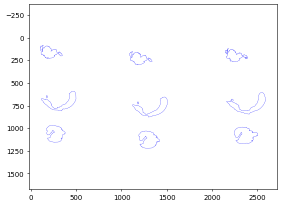

done translating
Set tile size to 2000 , and overlap to 1000
Done tiling the slide!
Number of sections in slide: 14
Number of tiles in current section: 95
done processing tiles in section 0
Number of tiles in current section: 2
done processing tiles in section 1
Number of tiles in current section: 141
done processing tiles in section 2
Number of tiles in current section: 9
done processing tiles in section 3
Number of tiles in current section: 94
done processing tiles in section 4
Number of tiles in current section: 162
done processing tiles in section 5
Number of tiles in current section: 2
done processing tiles in section 6
Number of tiles in current section: 8
done processing tiles in section 7
Number of tiles in current section: 9
done processing tiles in section 8
Number of tiles in current section: 166
done processing tiles in section 9
Number of tiles in current section: 157
done processing tiles in section 10
Number of tiles in current section: 102
done processing tiles in secti

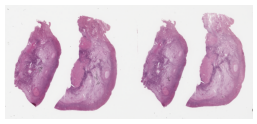

done cleaning


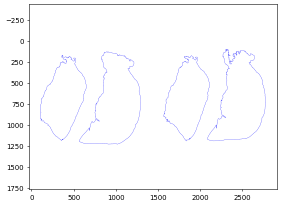

done translating
Set tile size to 2000 , and overlap to 1000
Done tiling the slide!
Number of sections in slide: 4
Number of tiles in current section: 1502
done processing tiles in section 0
Number of tiles in current section: 2135
done processing tiles in section 1
Number of tiles in current section: 1501
done processing tiles in section 2
Number of tiles in current section: 2082
done processing tiles in section 3
done with all sections
Detected  27488 raw bboxes on slide!
Len of unique preds on slide 7426
Done saving JSON!


In [21]:
failed = []
for i in range(len(slide_list)):


    slide_fname = Path(slide_dir + '/' + slide_list[i] + '.svs')
    print('Working on Slide ', i, ' ', slide_fname)

    slide = openslide.OpenSlide(str(slide_fname))
    print('opened slide!')
    levels = int(slide.level_count)
    thumb_dim = slide.level_dimensions[levels - 1]  # highest level corresponds to smallest available dimension
    thumbnail_downsample_factor = int(slide.level_downsamples[levels - 1])  # corresponding downsample factor of the thumbnail to be produced

    wsi_thumb = slide.get_thumbnail(thumb_dim)
    plt.imshow(wsi_thumb)
    plt.axis('off')
    plt.show()
    plt.cla()
    plt.clf()
    plt.close()

    wsi_thumbnail_mask = simple_get_mask(wsi_thumb)

    tissue_regions = get_tissue_regions(wsi_thumbnail_mask, thumbnail_downsample_factor)


    # jsons_fname = Path('/media/14TB/aarlova_ovarian/margin_jsons_for_NIH/' + slide_list[i] + '.geojson')
    # coords = read_geojson_nolabel(jsons_fname)
    # tissue_regions = [Polygon(i[0]) for i in coords]

    # coords, labels = read_geojson(jsons_fname)
    # tissue_regions = [Polygon(i[0]) for i in coords]


    #######################################################################
    # generate a grid of tiles of specific size and overlap within bounds of the Ovary
    print('Set tile size to', tile_size, ', and overlap to', overlap)
    slide_grid = get_grid(tissue_regions, tile_size, overlap, plot=False) # slide_grid is a nested list of Polygons. Len(slide_grid) is how many sections of tissue are on slide.
    print('Done tiling the slide!')

    #######################################################################
    # tile the slide with my script, get slide_grid
    print('Number of sections in slide:', len(slide_grid))

    slide_boxes = []

    for section in range(len(slide_grid)):
        print('Number of tiles in current section:', len(slide_grid[section]))


        for tile in range(len(slide_grid[section])):
            current_tile = slide_grid[section][tile]
            current_tile_top_left_coord = [int(current_tile.bounds[0]), int(current_tile.bounds[1])]  # this should be minx, miny if polygons were created with ccw=False
            # tile_name = str(out_tile_dir/slide_fname.stem) + '/' + str(slide_fname.stem) + ' [x=' + str(current_tile_top_left_coord[0]) + ',y=' + str(current_tile_top_left_coord[1]) + ',w='+str(tile_size) + ',h=' + str(tile_size) + '].jpg'
            tile_img = slide.read_region((current_tile_top_left_coord[0], current_tile_top_left_coord[1]),0,(tile_size,tile_size)).convert('RGB')
            resized_tile = tile_img.resize((500,500)) 


            #2. Predict on one individual tile at a time
            pred_dict  = model_type.end2end_detect(resized_tile, valid_tfms, model, class_map=class_map, detection_threshold=0.25)
            # pred_dict['img'].show()

            poly_boxes = []

            a = pred_dict['detection']['bboxes']
            if len(a) > 0:
                for b in a:
                    poly = box(b.xmin, b.ymin, b.xmax, b.ymax)
                    poly_boxes.append(poly)



            #3. Translate tile-relative coords of Polygon to WSI-relative coords
            for p in range(len(poly_boxes)):
                new_ext_x = np.array(poly_boxes[p].exterior.coords.xy[0]) * downsample + current_tile_top_left_coord[0]
                new_ext_y = np.array(poly_boxes[p].exterior.coords.xy[1]) * downsample + current_tile_top_left_coord[1]

                new_coords = list(zip(new_ext_x, new_ext_y))
                new_poly = Polygon(new_coords)
                slide_boxes.append(new_poly)


            tile_img.close()
            resized_tile.close()



        print('done processing tiles in section', section)



    print('done with all sections')

    slide.close()

    print('Detected ', len(slide_boxes), 'raw bboxes on slide!')


    ########### Make JSONs ###########
    ########### filter out 'too' rectangular polygons
    filtered = []
    for o in slide_boxes:
        x = o.bounds[2] - o.bounds[0]
        y = o.bounds[3] - o.bounds[1]

        abs_log_aspect_ratio_sample = abs(math.log(x/(y+0.000000001)))

        if abs_log_aspect_ratio_sample <= 0.5:
            filtered.append(o)
    # print('After filtered by aspect ratio', len(filtered))


    ########## remove intersecting whose intersection with other is greater than 50% of its area?
    tree = STRtree(filtered)

    all_merged = []
    for i in filtered:
        query_geom = i
        # intersects = [o for o in tree.query(query_geom) 
        #               if o.intersection(query_geom).area/unary_union([o,query_geom]).area > 0.5]
        intersects = [o for o in tree.query(query_geom) if o.intersection(query_geom).area/o.area > 0.5]

        merged = unary_union(intersects)
        all_merged.append(merged)

    # print('After merging intersecting polygons', len(all_merged))

    ############### remove duplicates from all_merged:
    all_merged_coords = [f.bounds for f in all_merged] # convert to list of coords in order to find unique polygons
    unique_merged = set(all_merged_coords)
    # print('Len of unique merged polygons after removing duplicates',len(unique_merged))
    unique_merged = [box(*u) for u in unique_merged] # back to Polygons

    ############### remove polygons that are covered by other polygons
    tree = STRtree(unique_merged)
    to_remove = []
    for i in unique_merged:
        query_geom = i
        covered_by = [o for o in tree.query(query_geom) if o.covered_by(query_geom) and not o.equals(query_geom)]
        to_remove.extend(covered_by) # list of polygons to remove

    ############### remove duplicates
    all_merged_coords = [f.bounds for f in unique_merged]
    to_remove_coords = [f.bounds for f in to_remove]
    unique_merged = set(all_merged_coords) - set(to_remove_coords)
    unique_merged = [box(*u) for u in unique_merged] # back to Polygons
    print('Len of unique preds on slide',len(unique_merged))

    ############## write JSON files
    slide_follicles = unique_merged
    slide_labels = ['Follicle' for f in slide_follicles]

    write_qupath_noIDs_Polys(str(json_dir) + '/' + str(slide_fname.stem) + '_fastRCNN.json', slide_follicles, slide_labels, region_colors)
    print('Done saving JSON!')
    # except:
    #     failed.append(slide_fname)

    # write all original preds
    # slide_labels = ['Follicle' for f in slide_boxes]
    # write_qupath_noIDs_Polys(str(json_dir) + '/' + str(slide_fname.stem) + '_fastRCNN_all.json', slide_boxes, slide_labels, region_colors)

# print('Failed to Infer with Object Detection', len(failed), failed)

### <font size="5">Visualize predictions (not required!)</font>

In [ ]:
fig, ax = plt.subplots()

ax.invert_yaxis()

# plot slide_boxes
patches = slide_follicles
color = ['r', 'g', 'b', 'c', 'y', 'm']
for j in range(len(patches)):
    x, y = np.array(patches[j].exterior.xy[0]), np.array(patches[j].exterior.xy[1])
    plt.plot(x, y, color=color[random.randint(0, 5)], linestyle='-', linewidth=0.4)
ax.grid(linestyle='--', linewidth='0.5')
plt.title("Slide Detections")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')
plt.show()
plt.cla()
plt.clf()
plt.close()
